In [2]:
pip install requests pandas

In [3]:
import pandas as pd

def read_csv(file_path):
    df = pd.read_csv('btc_dataset.csv')
    print(df.head())
    print("\nDataFrame Info:")
    print(df.info())
    print("\nDescriptive Statistics:")
    print(df.describe())

read_csv('BTC_transaction_volume.csv')


         Date          Open          High          Low    btc_price  \
0  01/02/2018  10237.299800  10288.799800  8812.280273  9170.540039   
1  02/02/2018   9142.280273   9142.280273  7796.490234  8830.750000   
2  03/02/2018   8852.120117   9430.750000  8251.629883  9174.910156   
3  04/02/2018   9175.700195   9334.870117  8031.220215  8277.009766   
4  05/02/2018   8270.540039   8364.839844  6756.680176  6955.270020   

         Volume  XRP_price  Ethereum_price   LTC_price  Oil_price  ...  \
0  9.959400e+09   0.962530     1036.790039  142.296997  65.800003  ...   
1  1.272690e+10   0.884784      915.784973  131.378998  65.449997  ...   
2  7.263790e+09   0.924043      964.018982  160.250000  65.449997  ...   
3  7.073550e+09   0.815703      834.682007  148.024994  65.449997  ...   
4  9.285290e+09   0.691799      697.950989  125.330002  64.150002  ...   

   MACD_Signal      RSI_7     RSI_14     RSI_30     RSI_60      Upper_BB  \
0     0.000000   0.000000   0.000000   0.000000   0.

In [4]:
import numpy as np

def clean_and_engineer_features(df):
    # 1. Data Cleaning
    # Drop any rows with missing values
    df = df.dropna()

    # Reset index after dropping rows
    df = df.reset_index(drop=True)

    # Handle outliers: For simplicity, we'll use z-score for outlier detection
    from scipy import stats
    z_scores = np.abs(stats.zscore(df.select_dtypes(include=np.number)))
    df = df[(z_scores < 3).all(axis=1)]

    # 2. Feature Engineering
    df['MA_7'] = df['btc_price'].rolling(window=7).mean()  # 7-day moving average
    df['MA_30'] = df['btc_price'].rolling(window=30).mean()  # 30-day moving average

    # Example: Calculate Daily Returns
    df['Return'] = df['btc_price'].pct_change()

    # Example: Calculate Volatility (Standard Deviation of Returns)
    df['Volatility'] = df['Return'].rolling(window=30).std()

    # Example: Adding Sentiment Score (Placeholder, assuming you have sentiment data)
    # This is a placeholder. Actual sentiment analysis would require text processing.
    df['Sentiment_Score'] = np.random.uniform(-1, 1, size=len(df))

    # Drop rows with NaN values generated by rolling operations
    df = df.dropna()

    # Reset index after adding new features
    df = df.reset_index(drop=True)

    # Display updated DataFrame info and head
    print("\nUpdated DataFrame Info:")
    print(df.info())

    print("\nFirst few rows after cleaning and feature engineering:")
    print(df.head())

    # Save the updated DataFrame to a new CSV file
    df.to_csv('cleaned_and_engineered_btc_data.csv', index=False)

df = pd.read_csv('btc_dataset.csv')
clean_and_engineer_features(df)



Updated DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2169 entries, 0 to 2168
Data columns (total 41 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               2169 non-null   object 
 1   Open               2169 non-null   float64
 2   High               2169 non-null   float64
 3   Low                2169 non-null   float64
 4   btc_price          2169 non-null   float64
 5   Volume             2169 non-null   float64
 6   XRP_price          2169 non-null   float64
 7   Ethereum_price     2169 non-null   float64
 8   LTC_price          2169 non-null   float64
 9   Oil_price          2169 non-null   float64
 10  Natural_Gas_price  2169 non-null   float64
 11  Gold_price         2169 non-null   float64
 12  Silver_price       2169 non-null   float64
 13  Nasdaq_price       2169 non-null   float64
 14  S&P500_price       2169 non-null   float64
 15  value              2169 non-null   int64  
 16 

In [5]:
import requests
from bs4 import BeautifulSoup
import re

def scrape_bloomberg(search_query, num_pages):
    base_url = "https://www.bloomberg.com/search"
    headers = {'User-Agent': 'Mozilla/5.0'}
    articles = []

    for page in range(num_pages):
        params = {'query': search_query, 'page': page}
        response = requests.get(base_url, headers=headers, params=params)
        soup = BeautifulSoup(response.content, 'html.parser')

        for item in soup.find_all('article'):
            title = item.find('a', class_='headline').get_text(strip=True)
            link = item.find('a', class_='headline')['href']
            article_url = f"https://www.bloomberg.com{link}"

            article_response = requests.get(article_url, headers=headers)
            article_soup = BeautifulSoup(article_response.content, 'html.parser')

            try:
                date = article_soup.find('time')['datetime']
            except TypeError:
                date = 'No date found'

            try:
                text = ' '.join(p.get_text(strip=True) for p in article_soup.find_all('p'))
            except AttributeError:
                text = 'No text found'

            articles.append({
                'title': title,
                'link': article_url,
                'date': date,
                'text': text
            })

    return articles

def scrape_reuters(search_query, num_pages):
    base_url = "https://www.reuters.com/search/news"
    headers = {'User-Agent': 'Mozilla/5.0'}
    articles = []

    for page in range(num_pages):
        params = {'blob': search_query, 'page': page}
        response = requests.get(base_url, headers=headers, params=params)
        soup = BeautifulSoup(response.content, 'html.parser')

        for item in soup.find_all('article'):
            title = item.find('h3').get_text(strip=True)
            link = item.find('a')['href']
            article_url = f"https://www.reuters.com{link}"

            article_response = requests.get(article_url, headers=headers)
            article_soup = BeautifulSoup(article_response.content, 'html.parser')

            try:
                date = article_soup.find('time')['datetime']
            except TypeError:
                date = 'No date found'

            try:
                text = ' '.join(p.get_text(strip=True) for p in article_soup.find_all('p'))
            except AttributeError:
                text = 'No text found'

            articles.append({
                'title': title,
                'link': article_url,
                'date': date,
                'text': text
            })

    return articles

def save_to_csv(articles, filename):
    df = pd.DataFrame(articles)
    df.to_csv(filename, index=False)

# Example usage
bloomberg_articles = scrape_bloomberg('Bitcoin', 1)
save_to_csv(bloomberg_articles, 'bloomberg_bitcoin_articles.csv')

reuters_articles = scrape_reuters('Bitcoin', 1)
save_to_csv(reuters_articles, 'reuters_bitcoin_articles.csv')


In [6]:
pip install praw

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.0/191.0 kB 5.6 MB/s eta 0:00:00


In [1]:
'''
import praw
from textblob import TextBlob

# Initialize Reddit API
def initialize_reddit():
    return praw.Reddit(
        client_id='ta1Bf0FW-0elp7fNY5UAAQ',
        client_secret='GMiW_hsJh0hufUGHPf4OWg-4t2HWGg',
        user_agent='smallcap.ai'
    )

# Fetch posts related to a specific keyword
def fetch_posts(reddit, keyword, limit=100):
    subreddit = reddit.subreddit('all')
    posts = []

    for submission in subreddit.search(keyword, sort='hot', limit=limit):
        posts.append({
            'title': submission.title,
            'url': submission.url,
            'score': submission.score,  # Upvotes
            'num_comments': submission.num_comments,
            'created_utc': submission.created_utc,
            'text': submission.selftext
        })

    return posts

# Analyze sentiment of the post text
def analyze_sentiment(text):
    if text:
        blob = TextBlob(text)
        return blob.sentiment.polarity
    return 0.0

# Main function to collect and process Reddit posts
def collect_reddit_data():
    reddit = initialize_reddit()

    # Fetch posts related to Bitcoin and Ethereum
    bitcoin_posts = fetch_posts(reddit, 'Bitcoin', limit=100)

    # Add sentiment analysis
    for post in bitcoin_posts:
        post['sentiment'] = analyze_sentiment(post['text'])

    # Convert to DataFrame and save to CSV
    bitcoin_df = pd.DataFrame(bitcoin_posts)

    bitcoin_df.to_csv('bitcoin_reddit_posts.csv', index=False)
    print("Data collection complete. Files saved as 'bitcoin_reddit_posts.csv'.")

# Example usage
collect_reddit_data()
'''

ModuleNotFoundError: No module named 'praw'

In [25]:
import praw
from datetime import datetime
from textblob import TextBlob

def get_reddit_data(start_date, end_date, query, limit=1000):
    reddit = praw.Reddit(
        client_id='ta1Bf0FW-0elp7fNY5UAAQ',
        client_secret='GMiW_hsJh0hufUGHPf4OWg-4t2HWGg',
        user_agent='smallcap.ai'
    )

    start_timestamp = int(datetime.strptime(start_date, '%Y-%m-%d').timestamp())
    end_timestamp = int(datetime.strptime(end_date, '%Y-%m-%d').timestamp())

    submissions = reddit.subreddit('all').search(
        query,
        sort='desc',
        time_filter='all',
        limit=limit
    )

    data = []
    for submission in submissions:
        created_utc = submission.created_utc
        if start_timestamp <= created_utc <= end_timestamp:
            data.append({
                'title': submission.title,
                'url': submission.url,
                'score': submission.score,
                'num_comments': submission.num_comments,
                'created_utc': datetime.utcfromtimestamp(created_utc).strftime('%Y-%m-%d'),
                'text': submission.selftext,
                'sentiment': submission.score  # Placeholder, to be updated with real sentiment analysis
            })

    df = pd.DataFrame(data)

    # Convert 'created_utc' to datetime
    df['created_utc'] = pd.to_datetime(df['created_utc'])

    # Perform sentiment analysis
    df['sentiment'] = df['text'].apply(lambda x: analyze_sentiment(x) if pd.notna(x) else 0)

    return df

def analyze_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Example usage
start_date = '2023-01-01'
end_date = '2024-08-23'
query = 'bitcoin'

df_reddit = get_reddit_data(start_date, end_date, query)

df_reddit.to_csv('reddit_data.csv', index=False)

print(df_reddit.info())
print(df_reddit.head())


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   title         110 non-null    object        
 1   url           110 non-null    object        
 2   score         110 non-null    int64         
 3   num_comments  110 non-null    int64         
 4   created_utc   110 non-null    datetime64[ns]
 5   text          110 non-null    object        
 6   sentiment     110 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 6.1+ KB
None
                                               title  \
0  PSA: I lost nearly all my bitcoin by mining bi...   
1        Can bitcoin really go to the moon anymore?    
2                                  Is bitcoin a buy?   
3                    Bitcoin explained in 23 seconds   
4                I asked AI to predict Bitcoin price   

                       

In [33]:
import re
from textblob import TextBlob

# Load Reddit Data
df_reddit = pd.read_csv('reddit_data.csv')

# Convert 'created_utc' to datetime format, handle errors by coercing invalid dates to NaT
df_reddit['created_utc'] = pd.to_datetime(df_reddit['created_utc'], errors='coerce')

# Define a function to clean text
def clean_text(text):
    if pd.isna(text):
        return '', 0.0  # Return empty text and neutral sentiment if text is missing
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove non-alphabetic characters and multiple spaces
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    # Compute sentiment
    sentiment = TextBlob(text).sentiment.polarity
    return text.strip(), sentiment

# Apply text cleaning and sentiment analysis
df_reddit[['text', 'sentiment']] = df_reddit['text'].apply(lambda x: pd.Series(clean_text(x)))

# Fill missing 'created_utc' values with a placeholder date (e.g., '1900-01-01')
df_reddit['created_utc'] = df_reddit['created_utc'].fillna(pd.to_datetime('1900-01-01'))

# Optionally, you can drop rows where 'text' is empty if it is critical to have non-empty text
df_reddit = df_reddit[df_reddit['text'].str.strip().astype(bool)]

# Check for missing values in the 'sentiment' column and fill them with a default value (e.g., 0.0)
df_reddit['sentiment'] = df_reddit['sentiment'].fillna(0.0)

# Save cleaned data
df_reddit.to_csv('cleaned_reddit_data.csv', index=False)

# Print cleaned data info
print(df_reddit.info())
print(df_reddit.head())


<class 'pandas.core.frame.DataFrame'>
Index: 48 entries, 0 to 108
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   title         48 non-null     object        
 1   url           48 non-null     object        
 2   score         48 non-null     int64         
 3   num_comments  48 non-null     int64         
 4   created_utc   48 non-null     datetime64[ns]
 5   text          48 non-null     object        
 6   sentiment     48 non-null     float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 3.0+ KB
None
                                               title  \
0  PSA: I lost nearly all my bitcoin by mining bi...   
1        Can bitcoin really go to the moon anymore?    
2                                  Is bitcoin a buy?   
4                I asked AI to predict Bitcoin price   
5       So i found an old bitcoin wallet from 2009!    

                             

In [34]:

df_reddit['created_utc'] = pd.to_datetime(df_reddit['created_utc'], unit='s')
df_reddit['Date'] = df_reddit['created_utc'].dt.date  # Extract the date

df_reddit = df_reddit.drop(columns=['created_utc'])

print("\nReddit DataFrame with Date column:")
print(df_reddit.head())



Reddit DataFrame with Date column:
                                               title  \
0  PSA: I lost nearly all my bitcoin by mining bi...   
1        Can bitcoin really go to the moon anymore?    
2                                  Is bitcoin a buy?   
4                I asked AI to predict Bitcoin price   
5       So i found an old bitcoin wallet from 2009!    

                                                 url  score  num_comments  \
0  https://www.reddit.com/r/Bitcoin/comments/1cr3...   1379           443   
1  https://www.reddit.com/r/Bitcoin/comments/1d13...    277           433   
2               https://i.redd.it/0ffeij9smhad1.jpeg    644           924   
4  https://www.reddit.com/r/Bitcoin/comments/162t...    275           231   
5                https://i.redd.it/yionalg4zq5d1.png   3040           814   

                                                text  sentiment        Date  
0  On August I spent exactly BTC on Antminer Sj P...   0.146218  2024-05-13  
1  Im ex

In [35]:
df['Date'] = pd.to_datetime(df['Date'])
df_reddit['Date'] = pd.to_datetime(df_reddit['Date'])

# Merge the DataFrames on Date
merged_df = pd.merge(df, df_reddit, on='Date', how='inner')

print("\nMerged DataFrame Info:")
print(merged_df.info())

print("\nFirst few rows of the merged data:")
print(merged_df.head())



Merged DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 42 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               48 non-null     datetime64[ns]
 1   Open               48 non-null     float64       
 2   High               48 non-null     float64       
 3   Low                48 non-null     float64       
 4   btc_price          48 non-null     float64       
 5   Volume             48 non-null     float64       
 6   XRP_price          48 non-null     float64       
 7   Ethereum_price     48 non-null     float64       
 8   LTC_price          48 non-null     float64       
 9   Oil_price          48 non-null     float64       
 10  Natural_Gas_price  48 non-null     float64       
 11  Gold_price         48 non-null     float64       
 12  Silver_price       48 non-null     float64       
 13  Nasdaq_price       48 non-null     float64 

In [37]:

# Check the first few rows
print(merged_df.head())

# Verify the data types and check for missing values
print(merged_df.info())

# Check for any NaN values in crucial columns
print(merged_df.isna().sum())

# Ensure that the 'Date' column is in datetime format
merged_df['Date'] = pd.to_datetime(merged_df['Date'], errors='coerce')

# Check if there are any date alignment issues
print(merged_df['Date'].min(), merged_df['Date'].max())

# Drop duplicate rows if any
merged_df = merged_df.drop_duplicates()

# Save cleaned data
merged_df.to_csv('cleaned_merged_data.csv', index=False)

# Print the final data info
print(merged_df.info())
print(merged_df.head())


        Date         Open         High          Low    btc_price  \
0 2023-04-17  30317.14648  30319.19727  29275.37109  29445.04492   
1 2023-08-27  26008.24219  26165.37305  25965.09766  26089.69336   
2 2023-11-03  34942.47266  34942.47266  34133.44141  34732.32422   
3 2023-11-09  35633.63281  37926.25781  35592.10156  36693.12500   
4 2023-11-23  37420.43359  37643.91797  36923.86328  37289.62109   

         Volume  XRP_price  Ethereum_price  LTC_price  Oil_price  ...  \
0  1.787219e+10   0.511127     2076.242920  98.674698  80.830002  ...   
1  6.913769e+09   0.523844     1657.513062  65.367111  79.830002  ...   
2  1.715846e+10   0.613002     1832.795166  69.491142  80.510002  ...   
3  3.776267e+10   0.667475     2120.561035  73.752213  75.739998  ...   
4  1.421495e+10   0.620242     2062.210693  69.512451  76.349998  ...   

       Lower_BB  btc_price_lag1  btc_price_lag2  btc_price_lag3  \
0  26886.199817     30315.35547     30318.49609     30485.69922   
1  24324.130868   

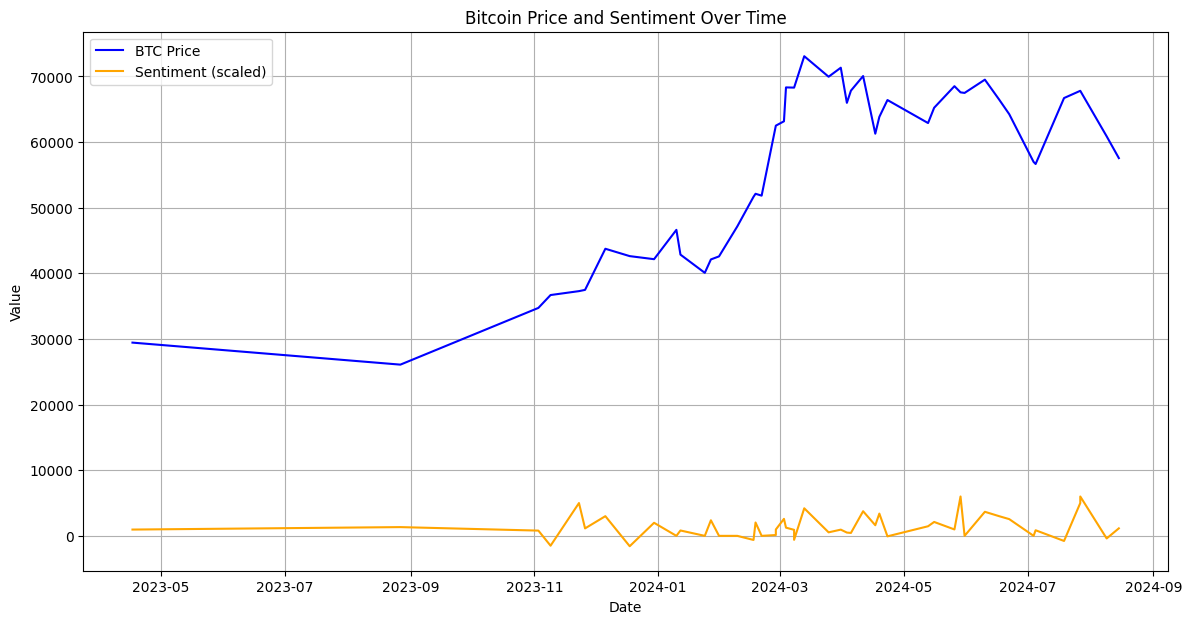

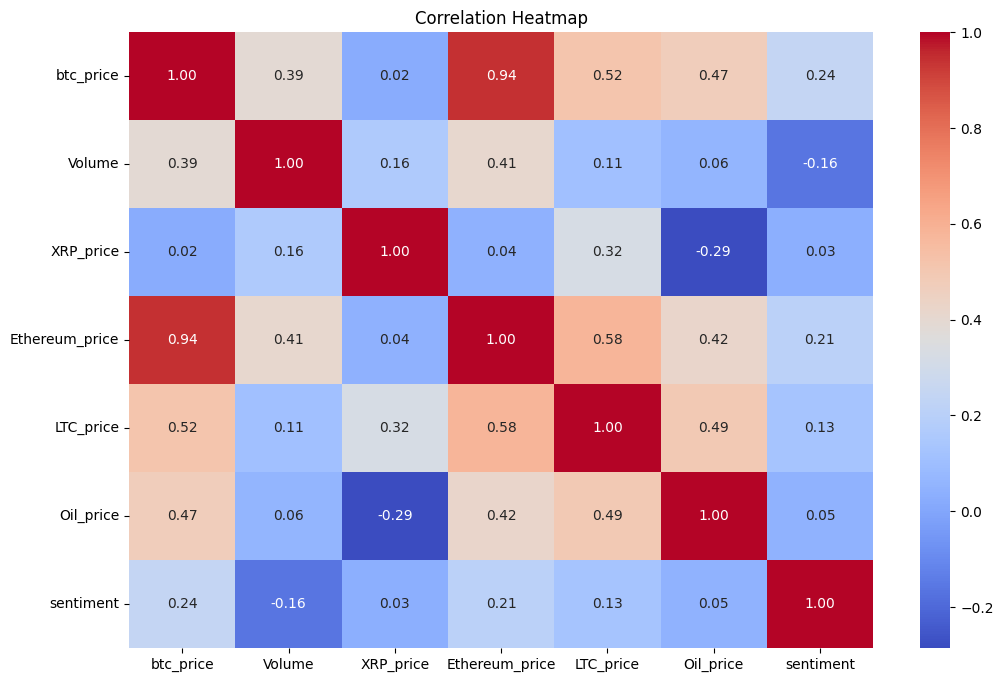

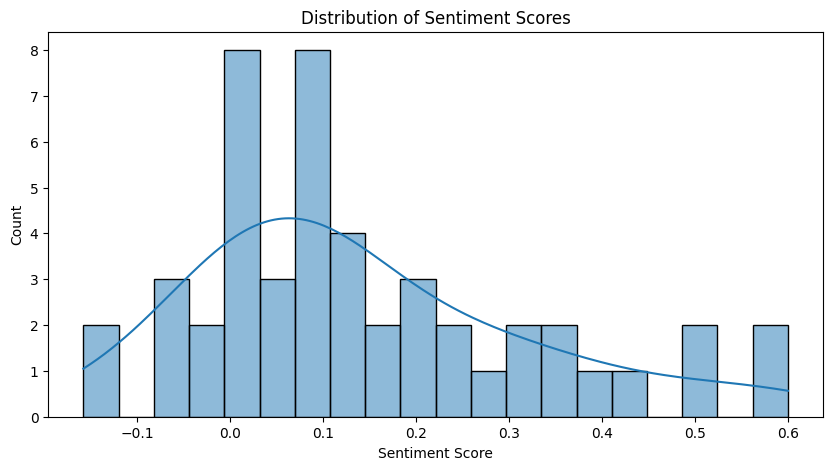

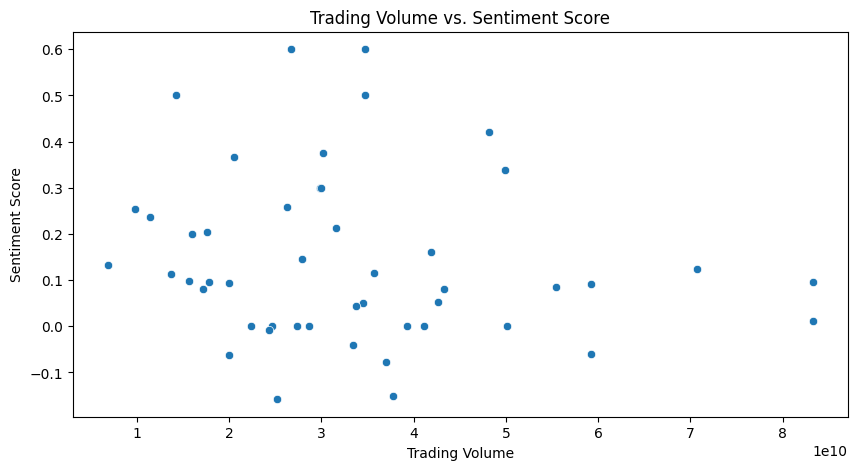

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned, merged DataFrame
df_merged = pd.read_csv('cleaned_merged_data.csv')

# Convert 'Date' to datetime if it's not already
df_merged['Date'] = pd.to_datetime(df_merged['Date'])

# Plot Bitcoin price and sentiment over time
plt.figure(figsize=(14, 7))
plt.plot(df_merged['Date'], df_merged['btc_price'], label='BTC Price', color='blue')
plt.plot(df_merged['Date'], df_merged['sentiment']*10000, label='Sentiment (scaled)', color='orange')  # Scaled sentiment for visibility
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Bitcoin Price and Sentiment Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Correlation heatmap for selected columns
selected_columns = ['btc_price', 'Volume', 'XRP_price', 'Ethereum_price', 'LTC_price', 'Oil_price', 'sentiment']
corr_matrix = df_merged[selected_columns].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# Distribution of sentiment scores
plt.figure(figsize=(10, 5))
sns.histplot(df_merged['sentiment'], bins=20, kde=True)
plt.xlabel('Sentiment Score')
plt.title('Distribution of Sentiment Scores')
plt.show()

# Relationship between trading volume and sentiment
plt.figure(figsize=(10, 5))
sns.scatterplot(x='Volume', y='sentiment', data=df_merged)
plt.xlabel('Trading Volume')
plt.ylabel('Sentiment Score')
plt.title('Trading Volume vs. Sentiment Score')
plt.show()


# **Random Forest**

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

df = pd.read_csv('cleaned_merged_data.csv')

# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Define the target variable and features
df['Price_Change'] = df['btc_price'].shift(-1) > df['btc_price']  # Create binary target: 1 if price goes up, 0 otherwise
df = df.dropna()  # Drop rows with NaN values resulting from shift

X = df.drop(columns=['Date', 'btc_price', 'Price_Change', 'title', 'url', 'text'])  # Drop non-numeric columns and target
y = df['Price_Change']

# Split the data into training + validation and test sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the temporary data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 of 0.8 = 0.2

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Validate the model
y_val_pred = rf_model.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)

print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation Precision: {val_precision}")
print(f"Validation Recall: {val_recall}")
print(f"Validation F1 Score: {val_f1}")

# Test the model
y_test_pred = rf_model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1 Score: {test_f1}")

# Hyperparameter tuning (optional, with GridSearchCV)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2', None],  # Removed 'auto'
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)


Validation Accuracy: 0.5
Validation Precision: 0.5
Validation Recall: 0.4
Validation F1 Score: 0.4444444444444445
Test Accuracy: 0.4
Test Precision: 0.6666666666666666
Test Recall: 0.2857142857142857
Test F1 Score: 0.4
Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best parameters found:  {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation score:  0.6814814814814815


# **LSTM**

In [54]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load your data
df = pd.read_csv('cleaned_merged_data.csv')

# Assume 'Price_Change' is the target variable and the rest are features
X = df.drop('Price_Change', axis=1)
y = df['Price_Change']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for LSTM
# Here, we assume each sample is a single timestep, so time_steps=1
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(Dense(1, activation='sigmoid'))  # Use 'softmax' for multi-class classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Predict on the test set
y_pred_probs = model.predict(X_test_reshaped)
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to class labels

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test F1 Score: {f1}")

# Optionally, plot training history
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


KeyError: "['Price_Change'] not found in axis"